In [1]:
import os
import sys 
import torch
from collections import Counter
import json
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sys.path.append("../utils/")
from plot_utils import EmbeddingPlotter

# Load embeddings and embedding to image mapping

In [3]:
# Read embeddings. Change filepaths as needed to visualize your embeddings
embeddings_fp = "../data/embeddings"
embeddings_path = embeddings_fp + "/resnext_embeddings.pt"
mapping_path = embeddings_fp + "/resnext_embeddings.json"
embeddings = torch.load(embeddings_path,map_location=torch.device('cpu'))

with open(mapping_path, 'r') as fp:
    idx2Img = json.load(fp)
    
idx2Img = dict(zip(list(map(int, idx2Img.keys())), list(idx2Img.values())))

In [4]:
# Update based on the location in your system
annot_file = "../../../coco/annotations/instances_val2014.json"

# Query images and their position in embedding space

In [5]:
# Img Ids to query
random.seed(10)
query_images = random.sample(list(idx2Img.values()), 10)

# Position of query images in embedding space
query_idxs = [key for key, value in idx2Img.items() if idx2Img[key] in query_images]

print("query image ids: ", query_images)
print("query image idxs: ", query_idxs)

query image ids:  [558661, 123071, 535156, 185614, 8493, 538859, 10583, 254976, 176847, 369594]
query image idxs:  [486, 1067, 6753, 9093, 14053, 15157, 15812, 16098, 18723, 18942]


# Initialize plotting utility

In [6]:
plotter = EmbeddingPlotter(annot_file = annot_file, embeddings=embeddings, idx2Img=idx2Img)

loading annotations into memory...
Done (t=4.38s)
creating index...
index created!


# Plot query images

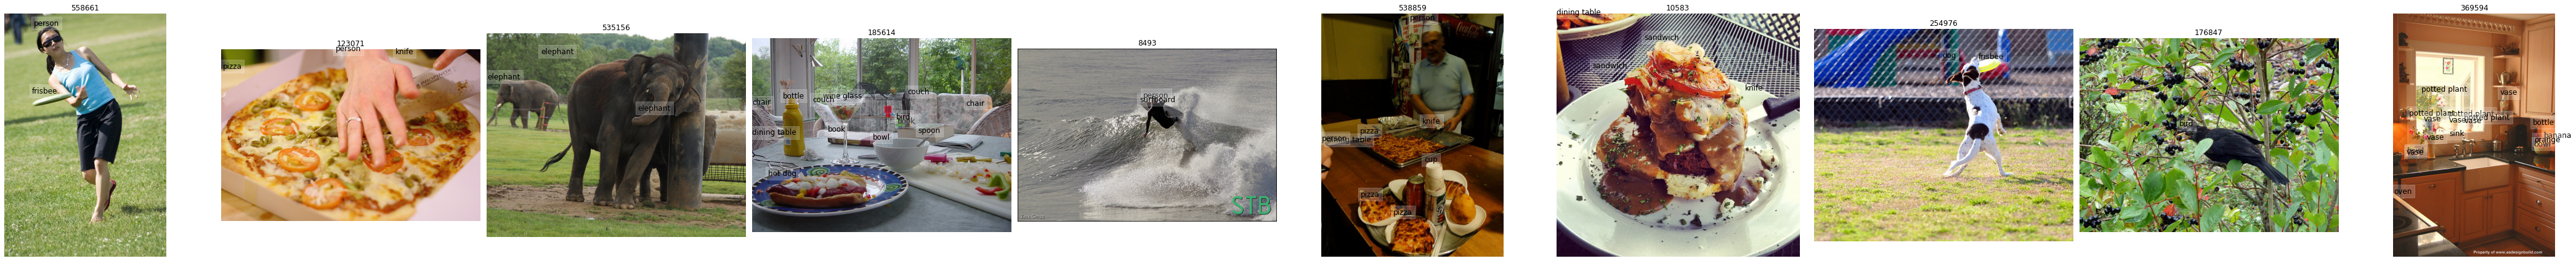

In [7]:
plotter.plot_coco_images([query_images])

# Use K-Neighbors to find similar images across embedded space

In [8]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='cosine').fit(embeddings)

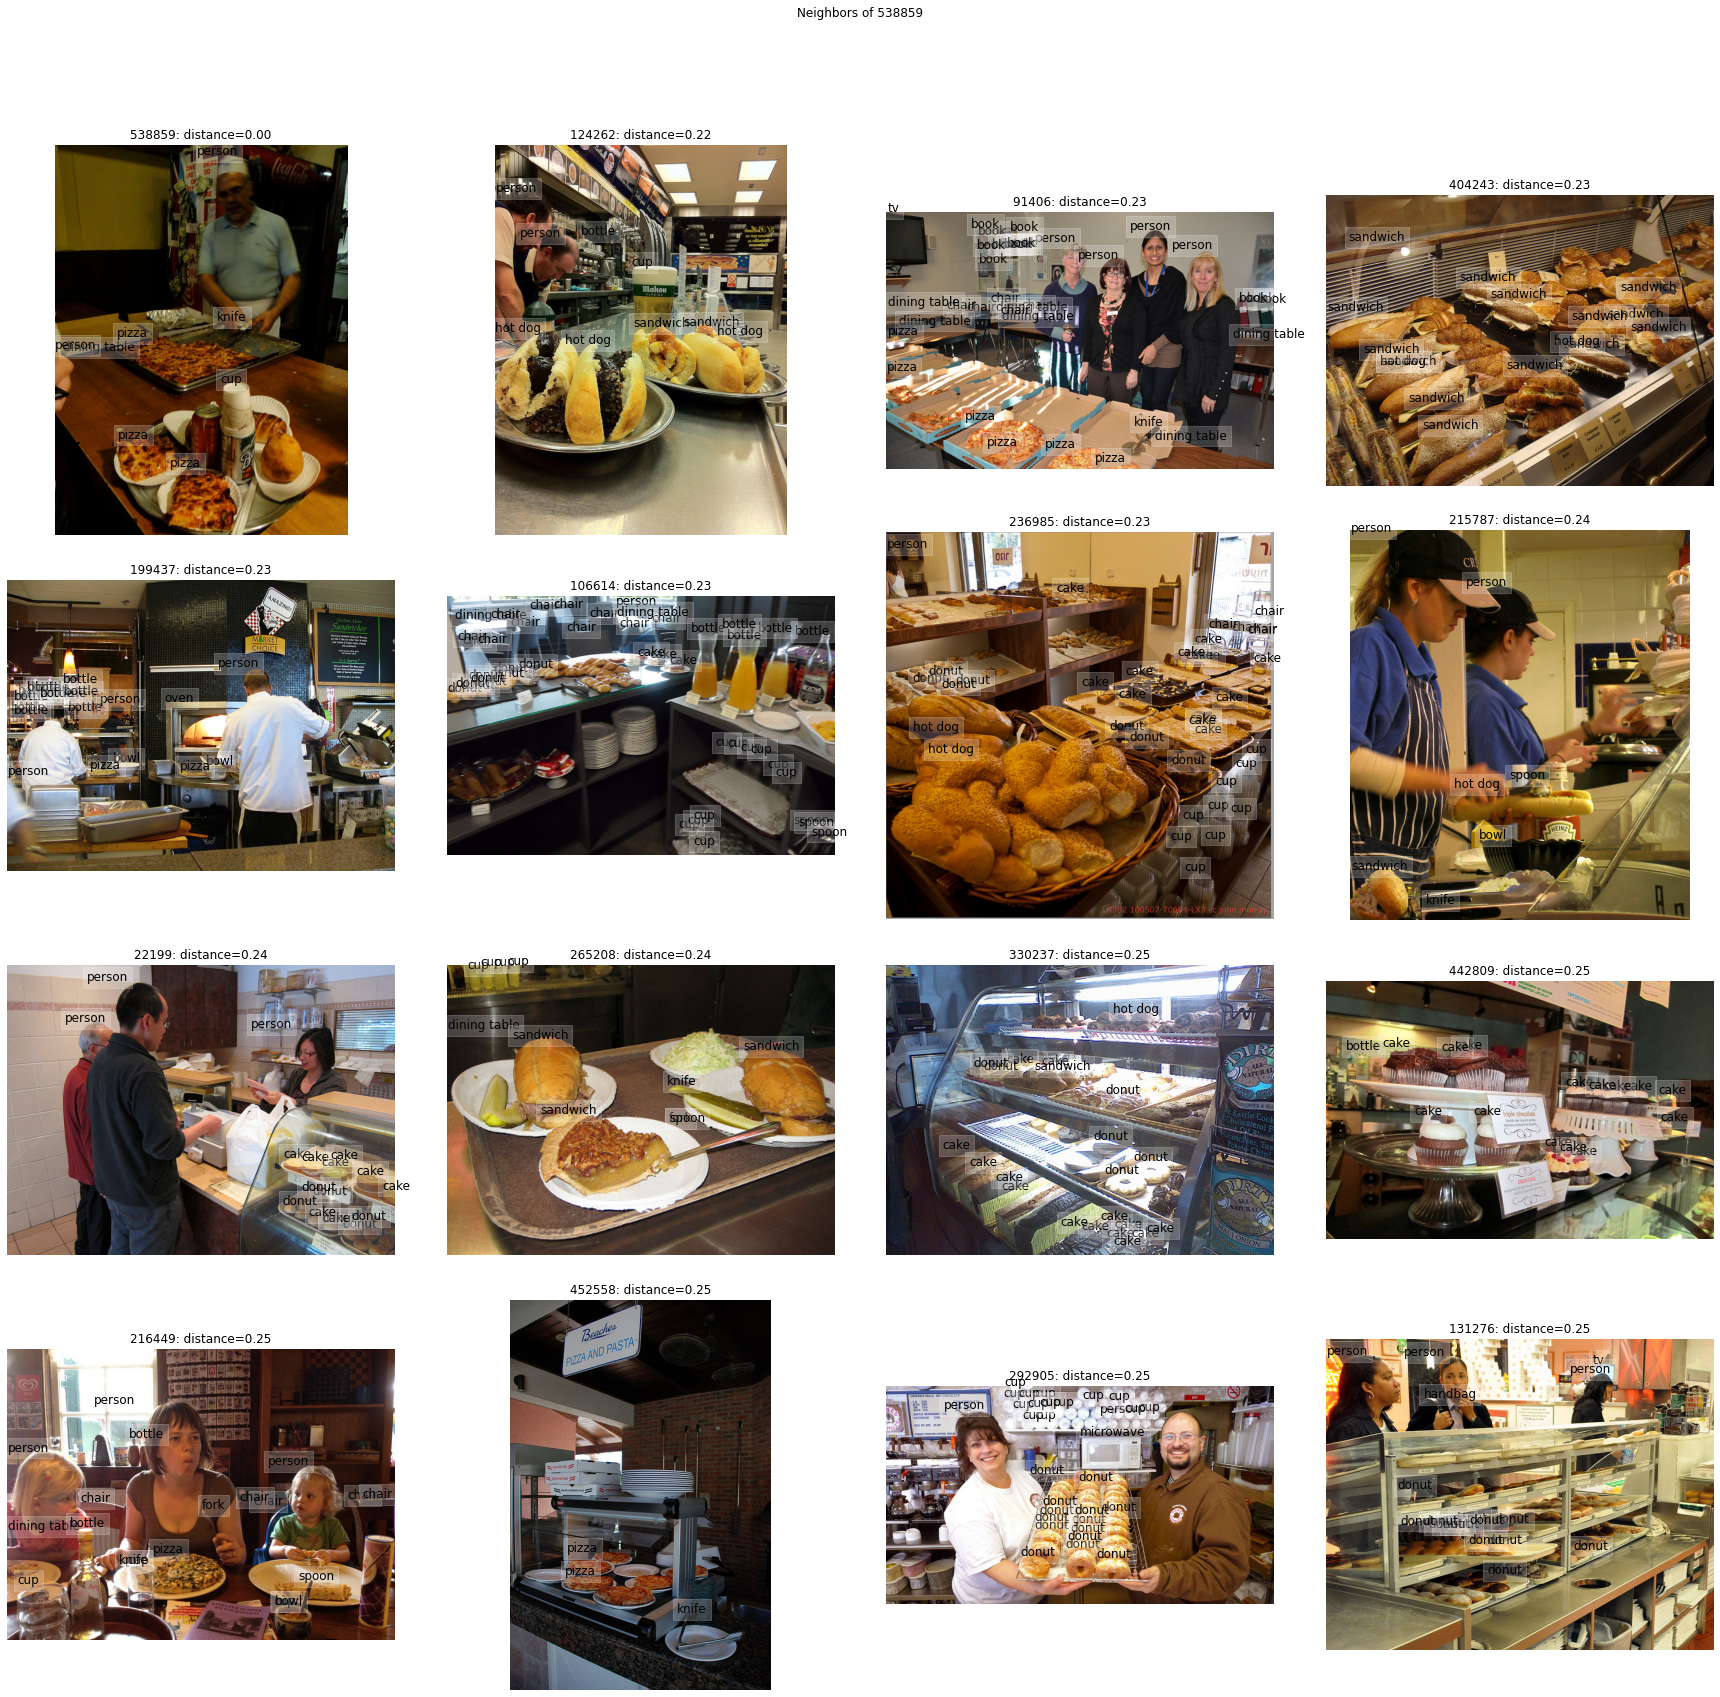

In [9]:
# Recall that plot_neighbors takes index position of embeddings as input
plotter.plot_neighbors(486, nbrs=nbrs)

# PCA on Embeddings

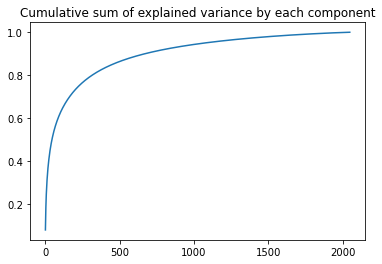

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=embeddings.shape[1])
X_pca = pca.fit_transform(embeddings)
plt.plot(range(X_pca.shape[1]), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum of explained variance by each component')
plt.show()

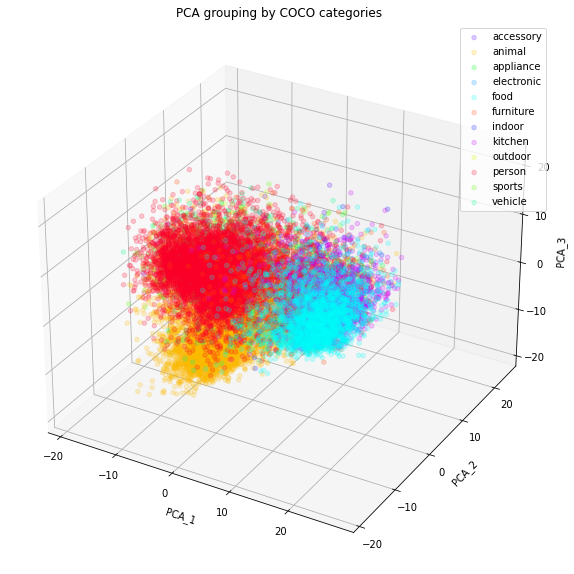

In [11]:
plotter.plot_3d(X=X_pca[:, :3], title='PCA grouping by COCO categories', columns=['PCA_1', 'PCA_2', 'PCA_3'], alpha=0.2)

# Search Precision

In [12]:
from operator import itemgetter

def precision(plotter, idx, nbrs, category=True, reduced_space=None):
    if reduced_space is None:
        embeddings = plotter.embeddings
        m, n = embeddings.size()
    else:
        embeddings = reduced_space
        m, n = np.shape(embeddings)
    distances, indices = nbrs.kneighbors(embeddings[idx, :].reshape(1, n), 16)
    distances = distances[0][1:]
    indices = indices[0][1:]
    if category == True:
        ground_truth = plotter.category_labels[idx]
        retrieved_labels = itemgetter(*indices)(plotter.category_labels)
    else:
        ground_truth = plotter.supercategory_labels[idx]
        retrieved_labels = itemgetter(*indices)(plotter.supercategory_labels)
        
    precision = np.array([1 if i == ground_truth else 0 for i in retrieved_labels]).sum() / len(retrieved_labels)
    return precision

In [13]:
def avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=None):
    avg_precision = 0
    for idx in query_idxs:
        avg_precision += precision(plotter, idx, nbrs, category, reduced_space)
    avg_precision = avg_precision / len(query_idxs)
    return avg_precision

In [14]:
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 53.33%
Supercategory-level precision: 42.0%


# Search Precision by K-Neighbors Distance Metric

In [15]:
# Cosine Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='cosine').fit(embeddings)
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 53.33%
Supercategory-level precision: 42.0%


In [16]:
# Minkowski Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='minkowski').fit(embeddings)
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 52.0%
Supercategory-level precision: 42.0%


In [17]:
# Euclidean Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='euclidean').fit(embeddings)
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 52.0%
Supercategory-level precision: 42.0%


In [18]:
# Manhattan Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='manhattan').fit(embeddings)
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False)
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True)
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 52.0%
Supercategory-level precision: 42.67%


# Search Precision in Reduced Space

In [19]:
# Cosine Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='cosine').fit(X_pca[:, :3])
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :3])
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :3])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 48.67%
Supercategory-level precision: 29.33%


In [20]:
# Minkowski Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='minkowski').fit(X_pca[:, :3])
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :3])
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :3])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 52.0%
Supercategory-level precision: 32.0%


In [21]:
# Euclidean Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='euclidean').fit(X_pca[:, :3])
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :3])
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :3])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 52.0%
Supercategory-level precision: 32.0%


In [22]:
# Minkowski Distance
nbrs = NearestNeighbors(n_neighbors=16, algorithm='auto', metric='manhattan').fit(X_pca[:, :3])
category_precision = avg_precision(plotter, nbrs, query_idxs, category=False, reduced_space=X_pca[:, :3])
supercategory_precision = avg_precision(plotter, nbrs, query_idxs, category=True, reduced_space=X_pca[:, :3])
print("Category-level precision: {}%".format(round(category_precision*100, 2)))
print("Supercategory-level precision: {}%".format(round(supercategory_precision*100, 2)))

Category-level precision: 49.33%
Supercategory-level precision: 34.0%
